In [13]:
json_path ="chunked_prefill-qps-1-input-len-128-tp-8.json"
import json

# Open and read the JSON file
with open(json_path, 'r') as file:
    data = json.load(file)

# Print the data
keys = data.keys()
values = data.values() 
print(keys)
print(type(data['date']))

dict_keys(['date', 'backend', 'model_id', 'tokenizer_id', 'num_prompts', 'request_rate', 'burstiness', 'max_concurrency', 'duration', 'completed', 'total_input_tokens', 'total_output_tokens', 'request_throughput', 'request_goodput:', 'output_throughput', 'total_token_throughput', 'input_lens', 'output_lens', 'ttfts', 'prefill_start_ts', 'prefill_start_counter', 'prefill_end_counter', 'prefill_end_ts', 'itls', 'errors', 'mean_ttft_ms', 'median_ttft_ms', 'std_ttft_ms', 'p99_ttft_ms', 'mean_tpot_ms', 'median_tpot_ms', 'std_tpot_ms', 'p99_tpot_ms', 'mean_itl_ms', 'median_itl_ms', 'std_itl_ms', 'p99_itl_ms'])
<class 'str'>


# Aggregate result

In [7]:
import os
import glob
import json
import re
import pandas as pd

# Regex to parse filenames like:
#   chunked_prefill-qps-1-input-len-1024-tp-8.json
FNAME_RE = re.compile(
    r'^(?P<tag>[^-]+)-qps-(?P<qps>\d+)-input-len-(?P<input_len>\d+)-tp-(?P<tp>\d+)\.json$'
)

# Only these metric keys will be extracted from each JSON
METRIC_KEYS = [
    "date",
    "backend",
    "num_prompts",
    "duration",
    "completed",
    "request_throughput",
    "output_throughput",
    "total_token_throughput",
    "mean_ttft_ms",
    "median_ttft_ms",
    "std_ttft_ms",
    "p99_ttft_ms",
    "mean_tpot_ms",
    "median_tpot_ms",
    "std_tpot_ms",
    "p99_tpot_ms",
    "mean_itl_ms",
    "median_itl_ms",
    "std_itl_ms",
    "p99_itl_ms",
]
def parse_filename_attributes(filename):
    base = os.path.basename(filename)
    m = FNAME_RE.match(base)
    if not m:
        raise ValueError(f"Filename {base!r} does not match expected pattern")
    return m.groupdict()

def gather_json_stats(input_folder, output_csv):
    rows = []
    for path in glob.glob(os.path.join(input_folder, '*.json')):
        # 1) filename-derived attributes
        attrs = parse_filename_attributes(path)

        # 2) load JSON and pick only desired metrics
        with open(path, 'r') as f:
            data = json.load(f)
        metrics = {k: data.get(k) for k in METRIC_KEYS}

        # 3) combine and append
        row = {**attrs, **metrics}
        rows.append(row)

    # 4) write out to CSV
    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False)
    print(f"Wrote {len(rows)} rows to {output_csv}")

if __name__ == '__main__':
    input_folder = '.'
    output_csv   = './all_metrics.csv'
    gather_json_stats(input_folder, output_csv)


Wrote 61 rows to ./all_metrics.csv


               mean_ttft_ms    p99_ttft_ms  mean_tpot_ms  p99_tpot_ms  \
input_len qps                                                           
1024      35   19975.542466   42043.016292    146.817499   228.448337   
2048      50   61822.437271  124670.830460    214.350882   268.324198   
          40   58846.747304  119068.664620    213.989064   267.526727   
          30   54483.948918  110452.473531    214.541375   267.187753   
128       20     157.225487     254.003608     46.569498    54.674969   

               mean_itl_ms  p99_itl_ms  request_throughput  output_throughput  \
input_len qps                                                                   
1024      35    142.746277  259.200159           12.148872        2677.794176   
2048      50    209.344251  290.213928            6.487842        1453.764539   
          40    209.073036  290.435404            6.521726        1468.235518   
          30    209.479444  291.561258            6.506004        1457.834149   
12

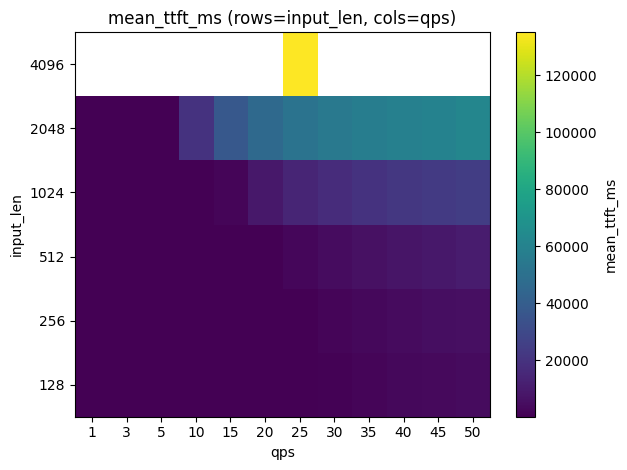

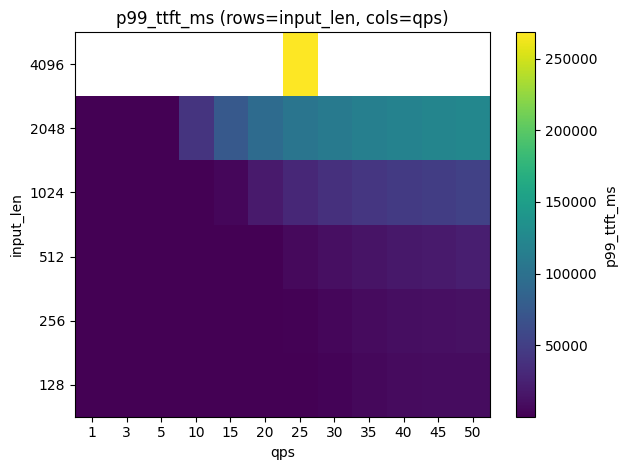

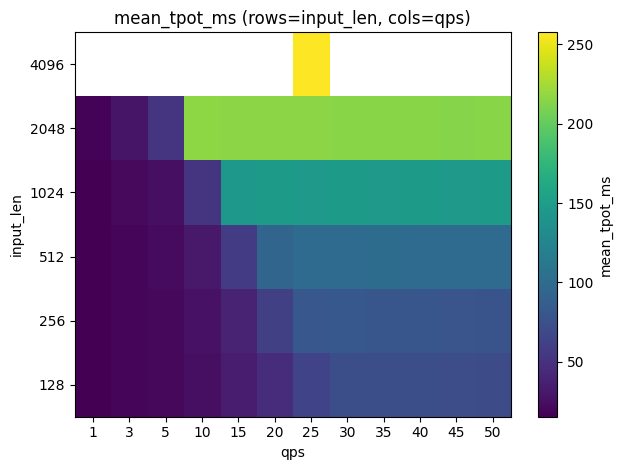

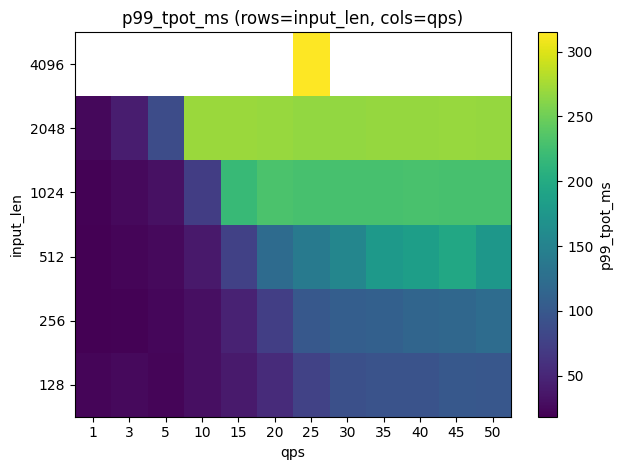

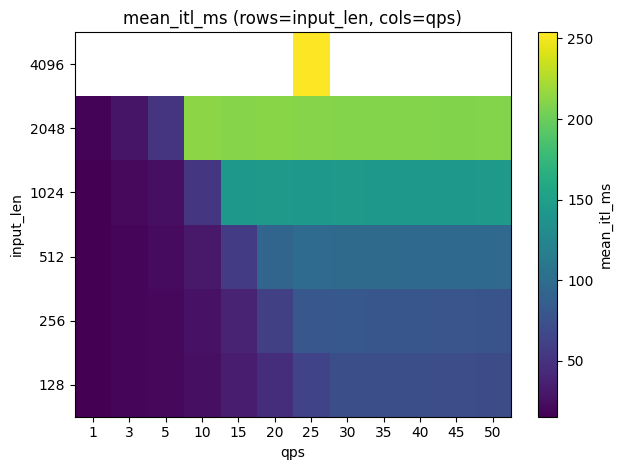

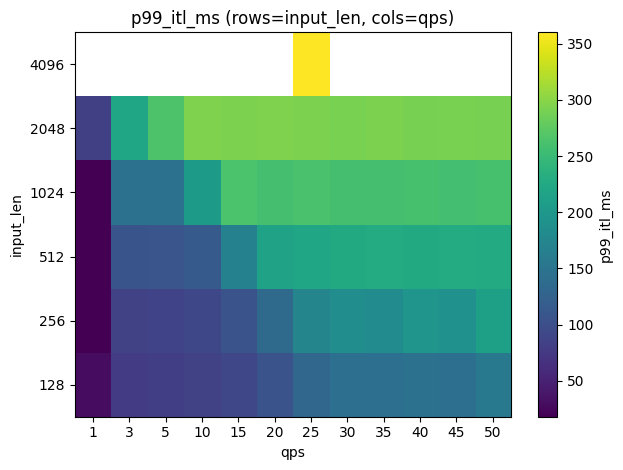

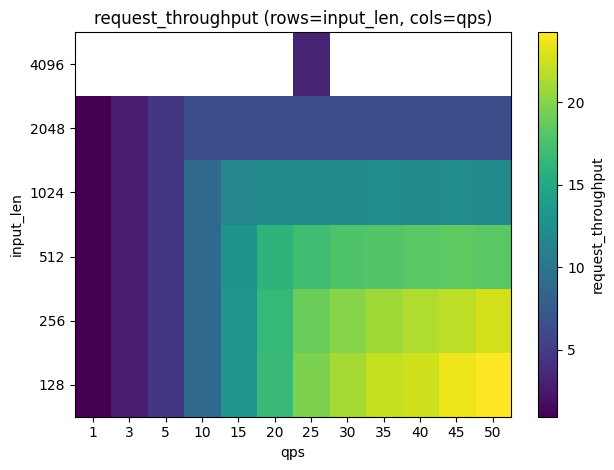

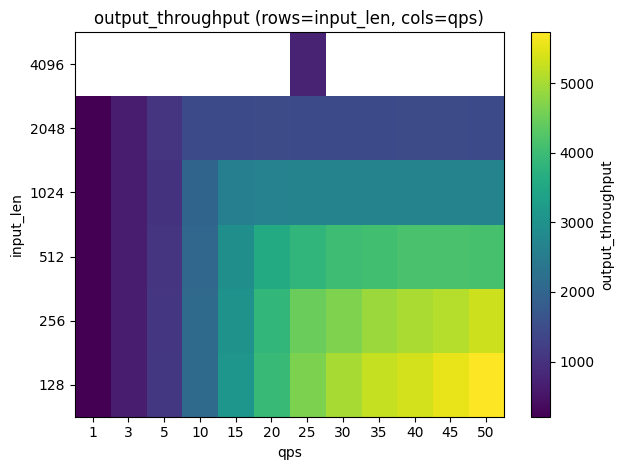

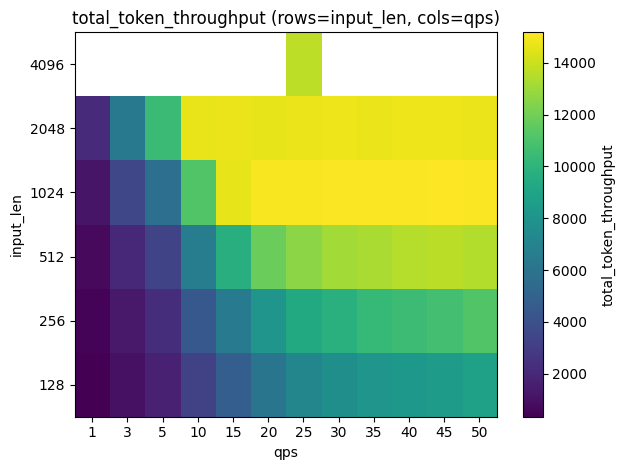

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# List of metrics to include as columns
METRIC_KEYS = [
    "mean_ttft_ms",
    "p99_ttft_ms",
    "mean_tpot_ms",
    "p99_tpot_ms",
    "mean_itl_ms",
    "p99_itl_ms",
    "request_throughput",
    "output_throughput",
    "total_token_throughput",
]

def load_and_pivot(csv_path):
    # 1) Read CSV
    df = pd.read_csv(csv_path)
    
    # 2) Coerce index columns
    df['input_len'] = df['input_len'].astype(int)
    df['qps']       = df['qps'].astype(int)
    
    # 3) Set a MultiIndex of (input_len, qps)
    df = df.set_index(['input_len', 'qps'])
    
    # 4) Keep only metric columns
    pivot = df[METRIC_KEYS]
    return pivot

def plot_heatmap(pivot_df, metric):
    """
    Given the pivoted DataFrame and a single metric name,
    plots a heatmap where rows are input_len, columns are qps.
    """
    data = pivot_df[metric].unstack(level='qps')  # rows=input_len, cols=qps
    plt.figure()
    plt.imshow(data, aspect='auto', origin='lower')
    plt.colorbar(label=metric)
    plt.title(f"{metric} (rows=input_len, cols=qps)")
    plt.xlabel("qps")
    plt.ylabel("input_len")
    plt.xticks(range(data.shape[1]), data.columns)
    plt.yticks(range(data.shape[0]), data.index)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    pivot_df = load_and_pivot("./all_metrics.csv")
    
    # Inspect the pivoted table
    print(pivot_df.head())
    
    # Plot heatmaps for each metric
    for metric in METRIC_KEYS:
        plot_heatmap(pivot_df, metric)


### Decode takes a hit when qps is increased. With Chunked prefill ttft is not affected as bad. Max qps we took for this analysis is 50 so with chunked prefill every batch would have 50 decodes (worst case) + 200

# Timestamp study

In [ ]:
import pandas as pd
import numpy as np
import json
import ast
from datetime import datetime, timedelta,timezone

csv_path = '/var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in128_qps1_chunked_prefill_tp1_0'
json_path = '/var/lib/jenkins/vllm/benchmarks/results/chunked_prefill-qps-1-input-len-128-tp-8.json'

def create_trace(csv_path,json_path,filename=None):

    df = pd.read_csv(csv_path)
    with open(json_path, 'r') as f:
        meta = json.load(f)
    prefill_start_ts_list = meta['prefill_start_ts'] 
   
    # Parse date and duration to get start time
    end_time = datetime.fromisoformat(meta['date'])
    duration = meta['duration']  # in seconds
    start_time = end_time - timedelta(seconds=duration)
    
    # 3. Generate timestamps for each row
    num_rows = len(df)
    timestamps = [start_time + timedelta(milliseconds=i) for i in range(num_rows)]

    # 4. Add to DataFrame 
    df['timestamp'] = timestamps


    # Prefill COncurreny
    prefill_ends_ts_list = meta['prefill_end_ts']

    prefill_starts_dt = pd.to_datetime(prefill_start_ts_list, unit='s')
    prefill_ends_dt = pd.to_datetime(prefill_ends_ts_list, unit='s')

    csv_timestamps = df['timestamp'].to_numpy()

    csv_timestamps = df['timestamp'].to_numpy()  # shape (num_rows,)

    prefill_starts_dt = np.array(prefill_starts_dt)  # shape (num_prefill,)
    prefill_ends_dt = np.array(prefill_ends_dt)      # shape (num_prefill,)

    prefill_concurrency = ((csv_timestamps[:, None] >= prefill_starts_dt) &
                        (csv_timestamps[:, None] < prefill_ends_dt)).sum(axis=1)
    df['prefill_concurrency'] = prefill_concurrency


    # Get decode timestamps

    prefill_ends = pd.to_datetime(prefill_ends_dt)      # pandas DatetimeIndex, (num_requests,)
    itl = meta['itls']                                  # list of lists, len = num_requests

    decode_ts = []  # List of lists

    for i, itl_row in enumerate(itl):
        times = []
        t = prefill_ends[i]
        for j, itl_val in enumerate(itl_row):
            times.append(t)
            t = t + timedelta(seconds=itl_val)
        decode_ts.append(times)


    # Algo for decode concurrency
    # 1. Build list of all interval events (start, +1) and (end, -1)
    events = []  # Each event is (time, +1/-1)
    for i, row in enumerate(decode_ts):
        for j in range(1, len(row)):
            events.append((row[j-1], +1))
            events.append((row[j], -1))

    # 2. Prepare CSV timestamps as queries
    csv_times = pd.to_datetime(df['timestamp']).to_numpy()
    csv_events = [(t, 0, idx) for idx, t in enumerate(csv_times)]  # (time, type, original index), type 0 for query

    # 3. Combine and sort all events (decode starts/ends and queries)
    # For sorting: type +1 (start) comes before 0 (query) comes before -1 (end) for same timestamp.
    all_events = []
    for (t, val) in events:
        all_events.append((t, 1 if val == +1 else -1, -1))  # (time, type, -1)
    for (t, typ, idx) in csv_events:
        all_events.append((t, 0, idx))

    # Sort: by time, then by type
    all_events.sort()

    # 4. Sweep through events, updating concurrency, record at each CSV query
    concurrency = np.zeros(len(csv_times), dtype=int)
    curr = 0
    for t, typ, idx in all_events:
        if typ == 1:      # decode start
            curr += 1
        elif typ == -1:   # decode end
            curr -= 1
        else:             # CSV timestamp query
            concurrency[idx] = curr

    df['decode_concurrency'] = concurrency


    # Inflight tokens
    df['prefill_token_inflight'] = np.where(
        df['prefill_concurrency'] > 0,
        2048 - df['decode_concurrency'],
        0
    )
    if filename:
        df.to_csv(filename, index=False)
    else:
        df.to_csv('metrics_with_timestamps.csv', index=False)
    


In [101]:
csv_path = '/var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in2048_qps50_chunked_prefill_tp1_0'
json_path = '/var/lib/jenkins/vllm/benchmarks/results/chunked_prefill-qps-50-input-len-2048-tp-8.json'

create_trace(csv_path,json_path,'2048_50.csv')

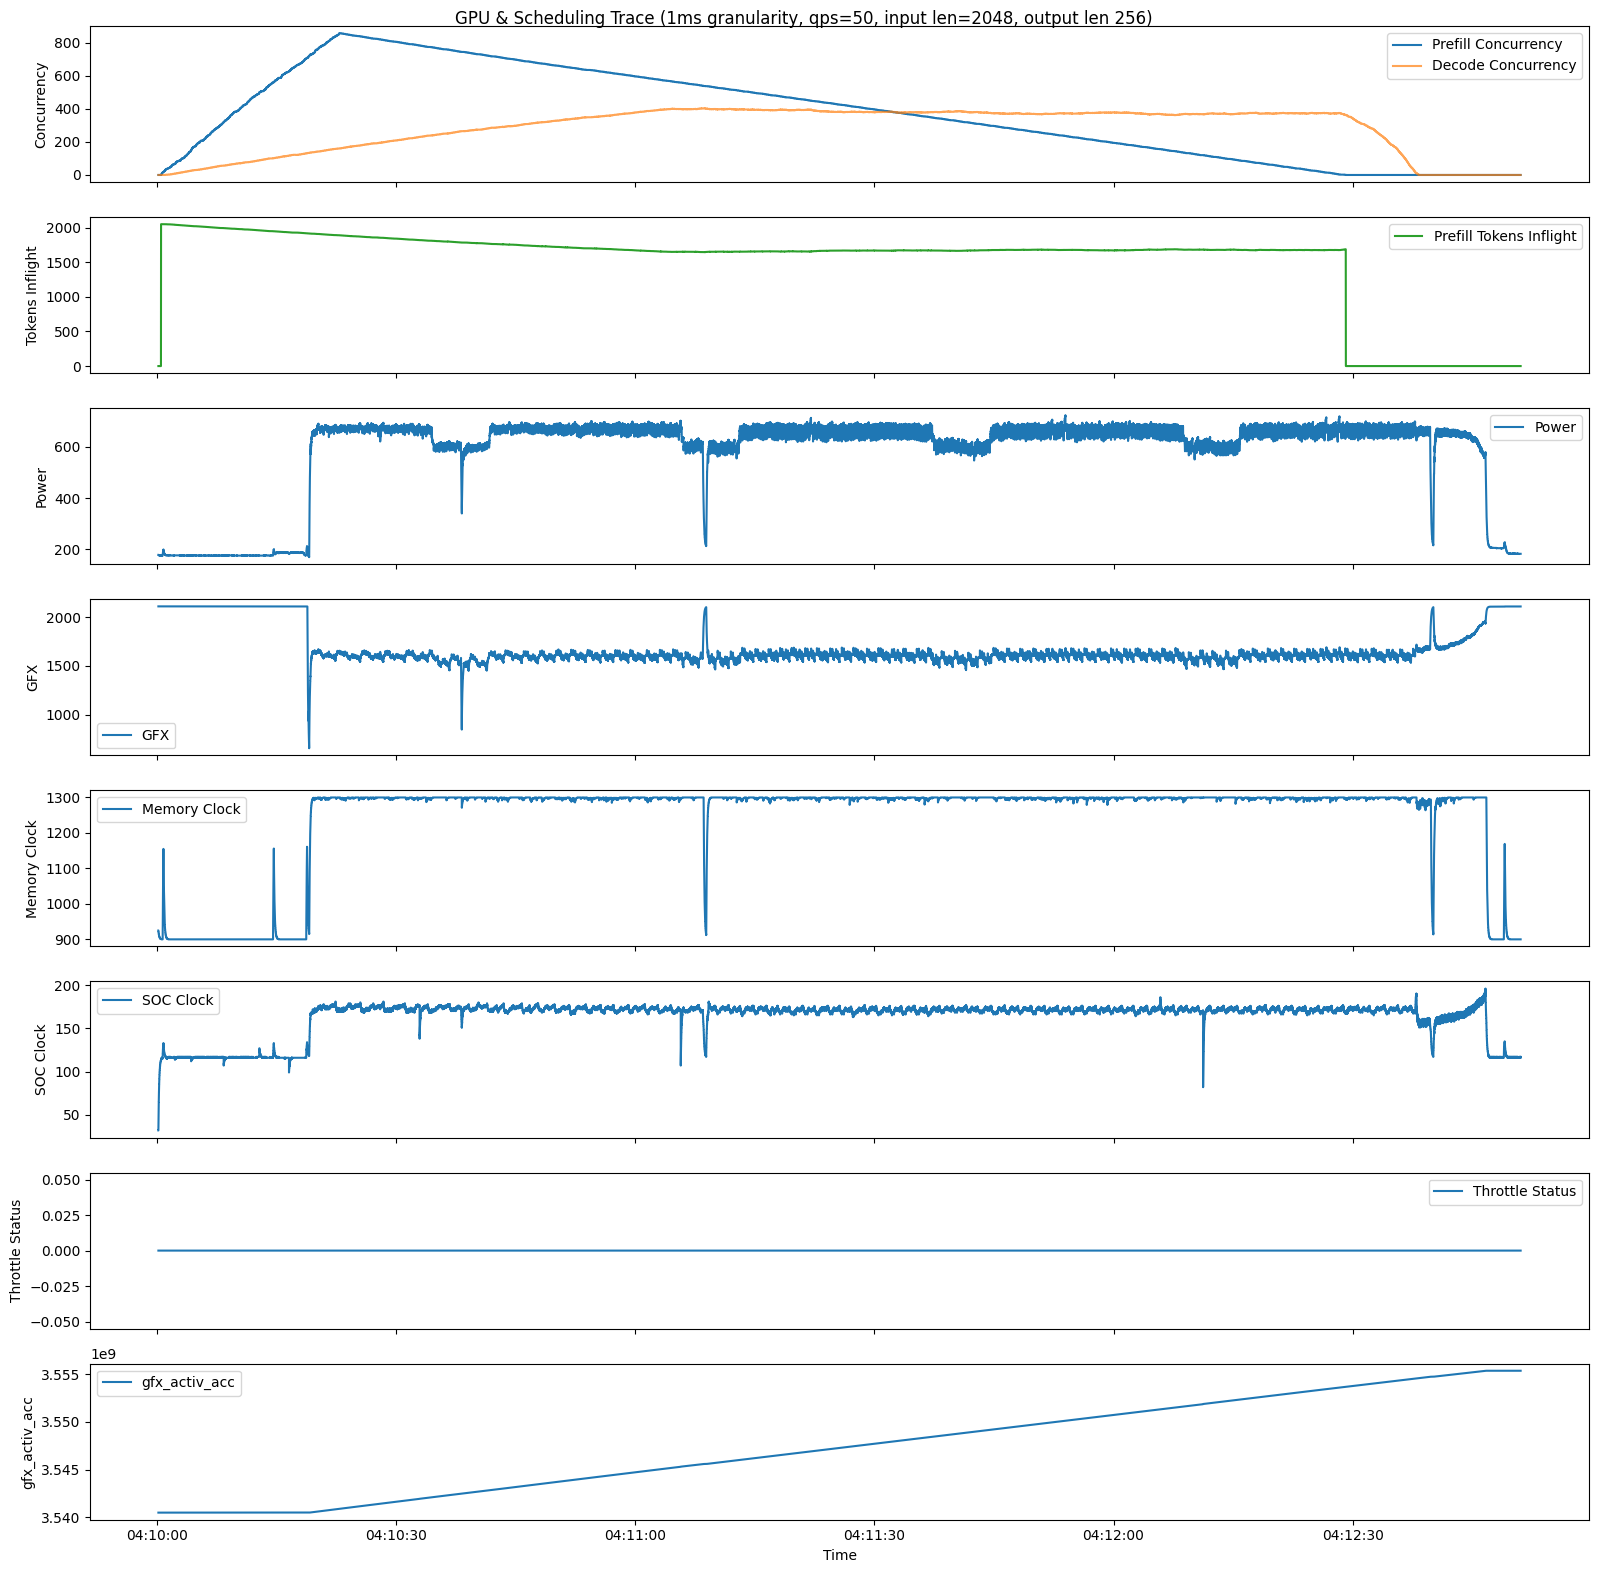

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
df= pd.read_csv('2048_50.csv')
def plot_gpu_trace(
    csv_path,
    start_time=None,      # string or pandas.Timestamp, or None
    end_time=None,        # string or pandas.Timestamp, or None
    metrics_to_plot=None, # list of column names to plot after ax0 and ax1
    metric_labels=None    # optional: pretty labels for each metric
):
    """
    Plots concurrency, tokens in flight (fixed), and any additional metrics you want.
    metrics_to_plot: list of DataFrame column names for extra subplots (optional).
    metric_labels: list of y-axis labels, or None to use column names.
    """
    df = pd.read_csv(csv_path)

    # Convert timestamp column to datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Filter by time range if specified
    if start_time is not None:
        df = df[df['timestamp'] >= pd.to_datetime(start_time)]
    if end_time is not None:
        df = df[df['timestamp'] <= pd.to_datetime(end_time)]

    if metrics_to_plot is None:
        metrics_to_plot = []  # default to no additional metrics
    n_metrics = len(metrics_to_plot)
    n_axes = 2 + n_metrics

    fig, axs = plt.subplots(n_axes, 1, figsize=(16, 2*n_axes), sharex=True)

    # Always plot concurrency (ax0)
    axs[0].plot(df['timestamp'], df['prefill_concurrency'], label='Prefill Concurrency')
    axs[0].plot(df['timestamp'], df['decode_concurrency'], label='Decode Concurrency', alpha=0.7)
    axs[0].set_ylabel('Concurrency')
    axs[0].legend()

    # Always plot prefill_token_inflight (ax1)
    axs[1].plot(df['timestamp'], df['prefill_token_inflight'], label='Prefill Tokens Inflight', color='tab:green')
    axs[1].set_ylabel('Tokens Inflight')
    axs[1].legend()

    # Plot user-selected metrics
    for i, col in enumerate(metrics_to_plot):
        label = metric_labels[i] if metric_labels and i < len(metric_labels) else col
        axs[2 + i].plot(df['timestamp'], df[col], label=label)
        axs[2 + i].set_ylabel(label)
        axs[2 + i].legend()

    plt.xlabel('Time')
    plt.suptitle('GPU & Scheduling Trace (1ms granularity, qps=50, input len=2048, output len 256)')
    plt.tight_layout()
    plt.show()

plot_gpu_trace(
    "2048_50.csv",
    # start_time='2025-07-08 04:10:00',
    # end_time='2025-07-08 04:11:00',
    metrics_to_plot=['curr_power', 'curr_gfxclk', 'curr_uclk', 'curr_socclk', 'throttle_status','gfx_activ_acc'],
    metric_labels=['Power', 'GFX', 'Memory Clock', 'SOC Clock', 'Throttle Status','gfx_activ_acc']
)


In [ ]:
print(df.value_counts())

NameError: name 'df' is not defined

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('2048_50.csv')

def plot_accumulated_utilization(
    df,
    timestamp_col='timestamp',
    accum_counters=None,
    labels=None,
    normalize=True,
    figsize=(16, 6)
):
    """
    Plots utilization from accumulated counters by diffing and normalizing.
    """
    ts = df[timestamp_col].values
    if labels is None:
        labels = accum_counters

    # Vectorized diff for all counters
    diff_df = df[accum_counters].diff().fillna(0)

    plt.figure(figsize=figsize)

    for col, label in zip(accum_counters, labels):
        diff = diff_df[col].values
        if normalize:
            max_val = 100
            util = (diff / max_val) * 100 if max_val != 0 else diff
            y_label = 'Utilization (%)'
        else:
            util = diff
            y_label = 'Raw Activity (per sample)'
        plt.plot(ts, util, label=label)

    plt.xlabel('Time')
    plt.ylabel(y_label)
    plt.legend()
    plt.title("Per-interval Utilization from Accumulated Counters")
    plt.tight_layout()
    plt.show()

plot_accumulated_utilization(df, accum_counters=['gfx_activ_acc'], labels=['GFX Util'])


KeyboardInterrupt: 